# SF Crime Statistical Analysis

In [9]:
# Import necessary modules
from scipy.stats import poisson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [10]:
# Grab dataframe containing police reports
# Create df on Macbook
df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_1_data/merged.csv")

# Create df on PC
# df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_1_data/merged.csv")
df = df.drop(columns='Unnamed: 0')
df.head()

,Incident Number,Incident Category,Incident Description,Incident Day of Week,Incident Date,Incident Time,Police District,Resolution,Intersection,Longitude,Latitude,point,Row ID,Incident Year,Analysis Neighborhood
0,100087859,"SEX OFFENSES, FORCIBLE",ANNOY OR MOLEST CHILDREN,Wednesday,2003-01-01,00:01,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",10008785914010,2003,South of Market
1,91139945,"SEX OFFENSES, FORCIBLE",SEXUAL BATTERY,Wednesday,2003-01-01,00:01,BAYVIEW,DISTRICT ATTORNEY REFUSES TO PROSECUTE,200 Block of BRIDGEVIEW DR,-122.397590,37.734209,"(37.7342093398821, -122.397590096788)",9113994504144,2003,Bayview Hunters Point
2,81360718,EMBEZZLEMENT,"EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE",Wednesday,2003-01-01,00:01,RICHMOND,NONE,2900 Block of PACIFIC AV,-122.443835,37.792137,"(37.7921365604231, -122.443835267233)",8136071810045,2003,Pacific Heights
3,81313927,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Wednesday,2003-01-01,00:01,MISSION,NONE,500 Block of GUERRERO ST,-122.424037,37.762751,"(37.7627513875316, -122.424036887526)",8131392764070,2003,Mission
4,81183231,FORGERY/COUNTERFEITING,"FORGERY, DRIVERS LICENSE OR ID-CARD",Wednesday,2003-01-01,00:01,NORTHERN,NONE,3000 Block of FILLMORE ST,-122.435517,37.797573,"(37.7975726990109, -122.435517480769)",8118323109120,2003,Marina


In [11]:
# Get Series of Year and the number of crime reports for that year
num_reports_by_year = df['Incident Year'].value_counts().sort_index()

# Drop 2019 from num_reports_by_year since 2019 is not fully updated
num_reports_by_year = num_reports_by_year[0:16]

# Change "Police District" column to lower case for consistency
df["Police District"] = df["Police District"].str.lower()

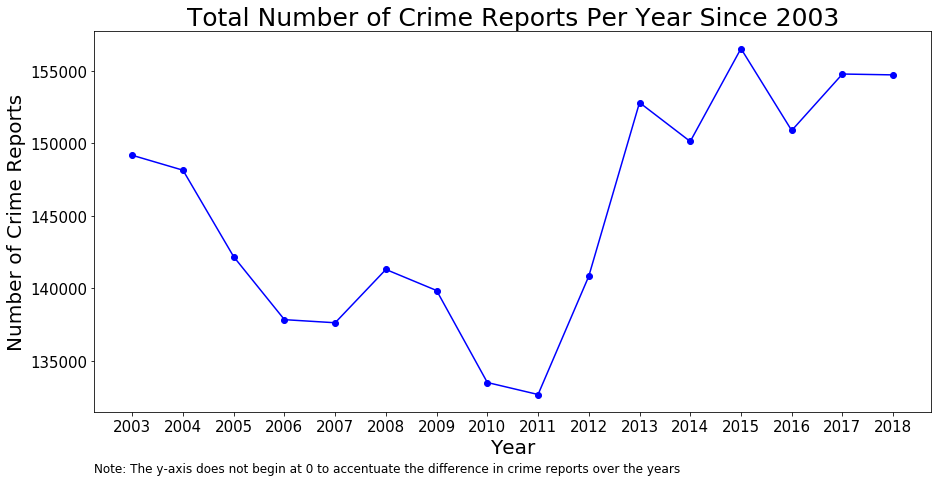

In [12]:
# Create figure for number of crime reports and plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(num_reports_by_year.index, num_reports_by_year.values, 'o-b')

# Set title and axis labels
ax.set_title("Total Number of Crime Reports Per Year Since 2003", fontsize=25)
ax.set_xlabel("Year", fontsize=20)
ax.set_ylabel("Number of Crime Reports", fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

# Show all years on x-axis
plt.xticks(num_reports_by_year.index)

# Add footnote
plt.annotate('Note: The y-axis does not begin at 0 to accentuate the difference in crime reports over the years', (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=12)

plt.show()

# Crime Report Rate: Is the change in crime rate statistically significant?

From the above graph, it is clear that some years were better/worse than others. 2011 saw the lowest crime report rate in the past 15 years, whereas in 2015 the crime report rate reached its peak. I want to focus on the number of crime reports per year to see if crime rate has changed since 2003. Since I want to measure the number of arrivals (crimes) per unit of time, using a Poisson random variable would be ideal. <br>

My crime poisson random variables must satisfy a few assumptions: <br>
-*Independence*: Events must be independent (one crime cannot impact the probability of another crime)<br>
-*Homogeneity*: The mean number of crimes is assumed to be the same for all neighborhoods.<br>
-*Time period*: must be fixed<br>

There are a few issues that I must address. San Francisco contains many neighborhoods, some of which are culturally, demographically, or financially different. Mean crime rate in one neighborhood will definitely not be the same for other neighborhoods. Crimes from adjacent neighborhoods may have an influence on each other as well. Because of these conditions, I will examine crime rate per neighborhood per year. By isolating neighborhoods and exploring their individual crime rates since 2003, I can reliably assume the requirements for my poisson random variable.

In [21]:
district_counts = pd.DataFrame(df['Police District'].value_counts())
district_counts = district_counts.reset_index()
district_counts.columns = ['Police District', 'Number of Reports']
district_counts

,Police District,Number of Reports
0,southern,422414
1,mission,326998
2,northern,298486
3,central,259736
4,bayview,236703
5,tenderloin,213807
6,ingleside,207715
7,taraval,180113
8,park,134481
9,richmond,128340


In [28]:
def graph_neighborhood(df, district, mean_dict, yearly_dict):
    """Graphs number of crimes for specific district from 2003-2018"""
    
    # Initialize police district dataframe
    df_pd = df[df["Police District"] == district]
    
    # Get number of crimes per year and drop 2019
    num_reports_by_year = df_pd['Incident Year'].value_counts().sort_index()
    num_reports_by_year = num_reports_by_year[0:16]
    
    # Create figure for number of crime reports and plot
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.plot(num_reports_by_year.index, num_reports_by_year.values, 'o-b')

    # Set title and axis labels
    ax.set_title(district + ": Crime Reports Per Year Since 2003", fontsize=25)
    ax.set_xlabel("Year", fontsize=20)
    ax.set_ylabel("Number of Crime Reports", fontsize=20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)

    # Show all years on x-axis
    plt.xticks(num_reports_by_year.index)
    
    # Start y-axis at 0 for consistency
    ax.set_ylim(bottom=0)
    
    # Add mean line and update dictionaries
    avg = num_reports_by_year.mean()
    ax.axhline(avg, ls='--', label="Mean")
    mean_dict[pd] = avg
    yearly_dict[pd] = list(num_reports_by_year)
    
    ax.legend(loc="lower right", prop={'size': 15})

    plt.show()

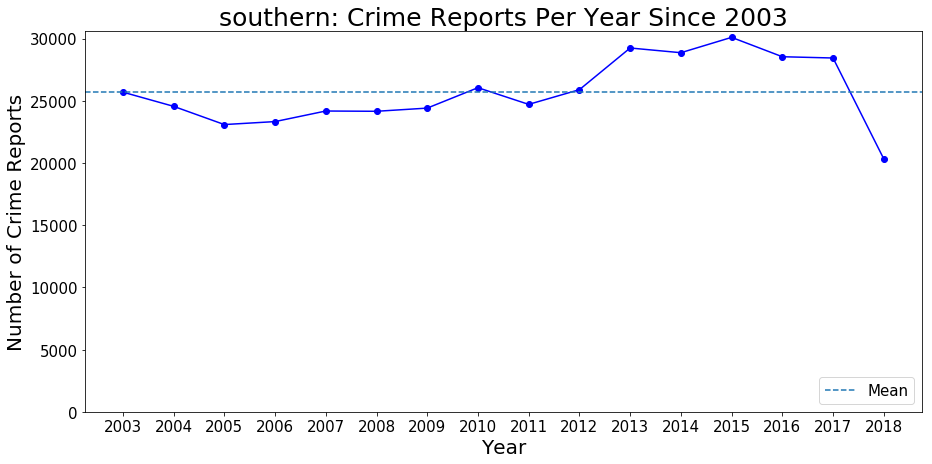

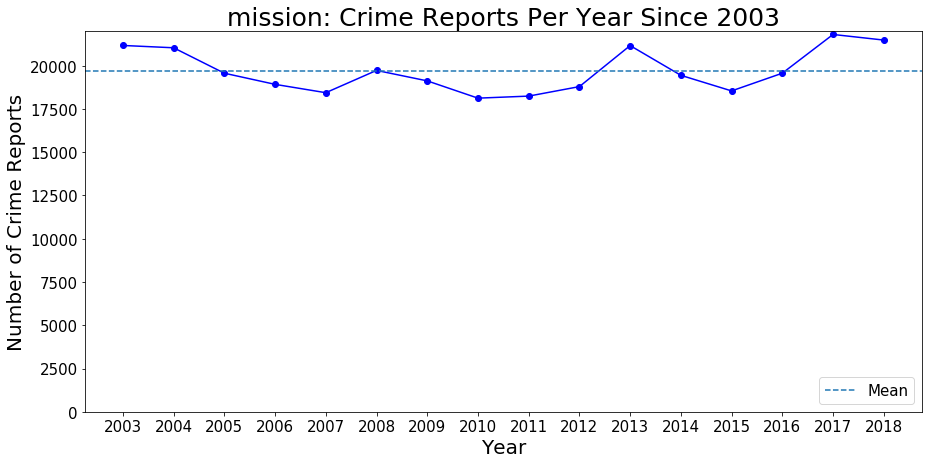

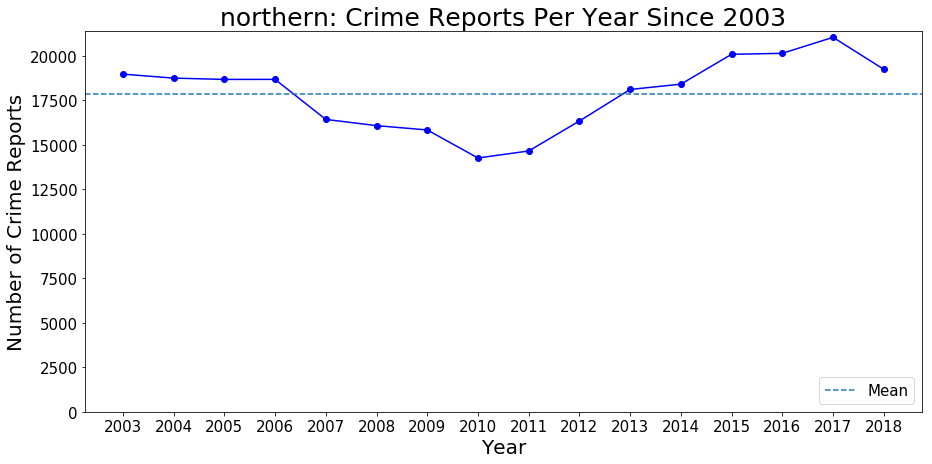

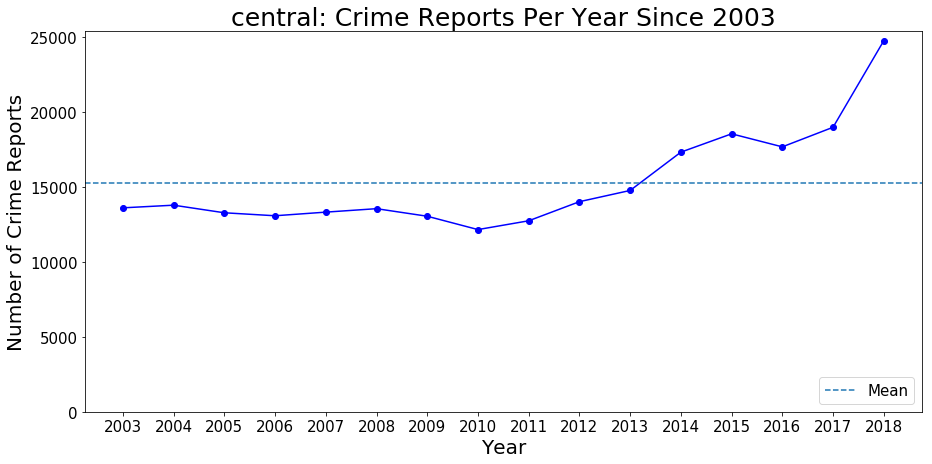

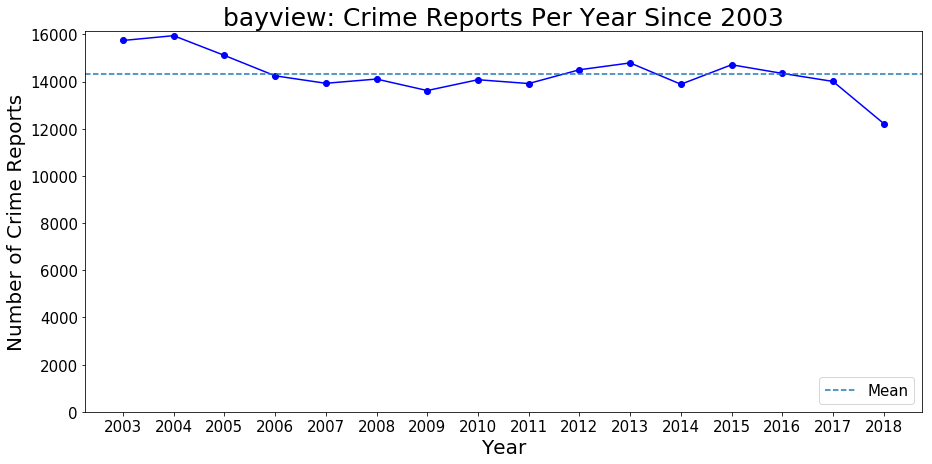

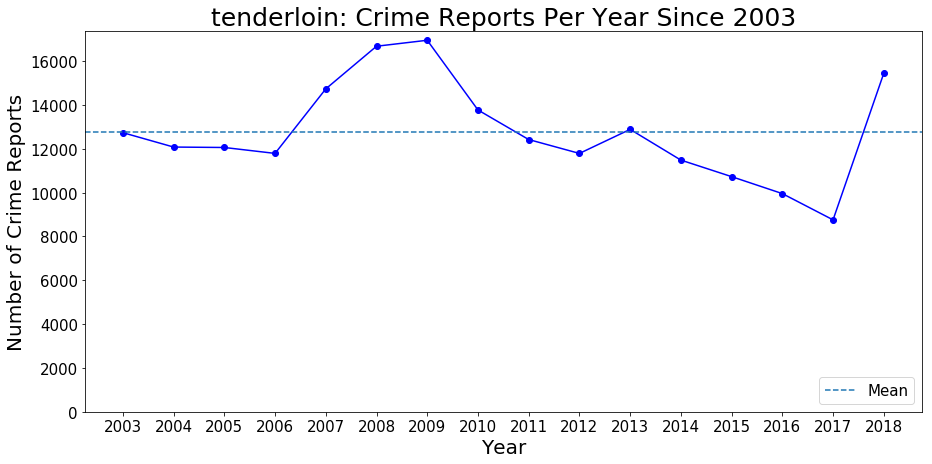

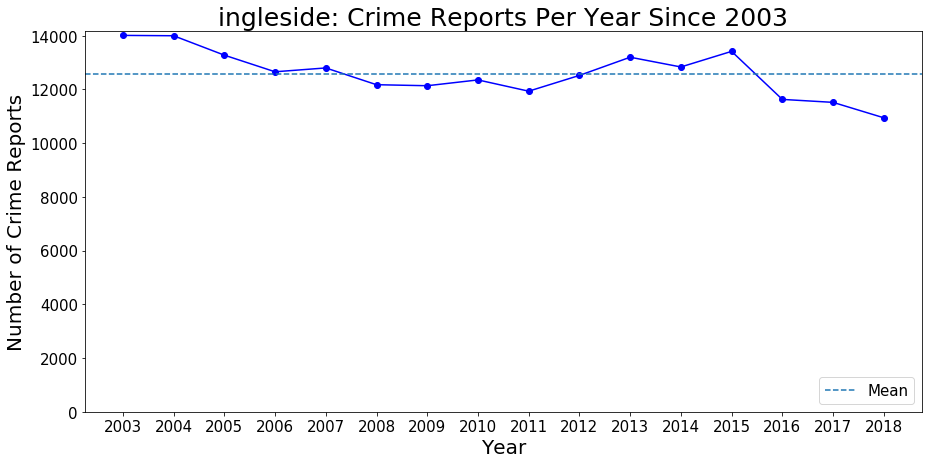

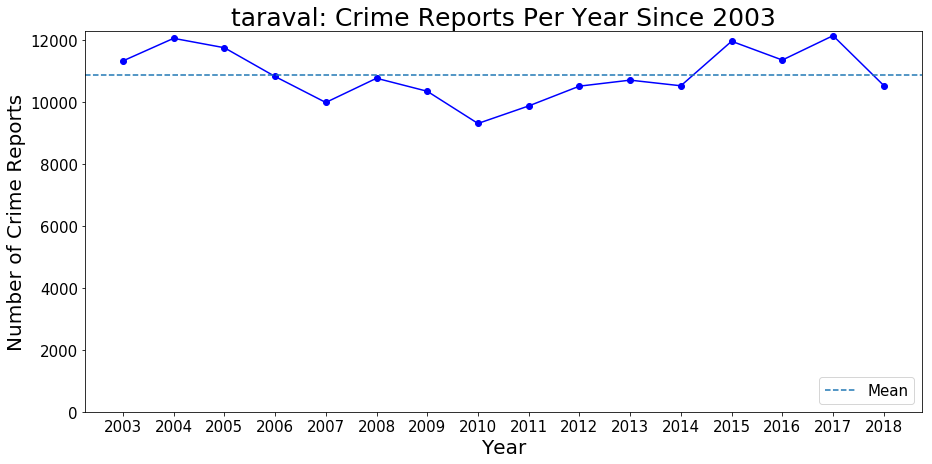

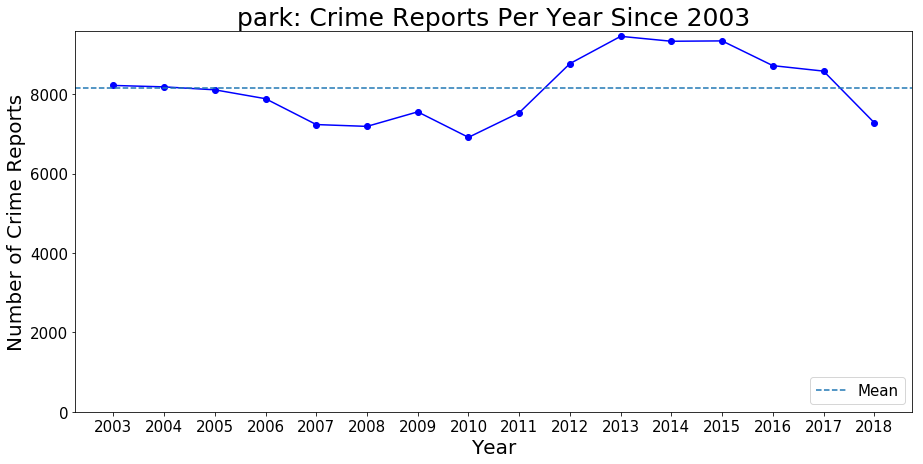

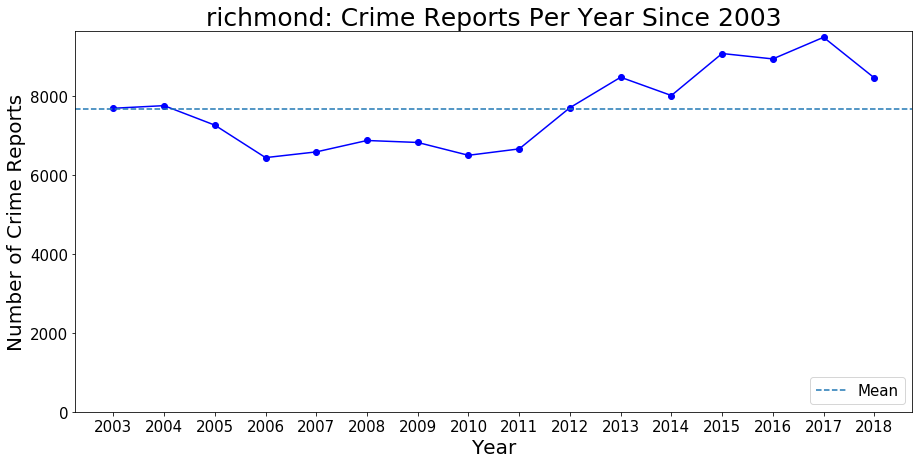

In [30]:
# Plot individual police districts
districts = list(district_counts["Police District"])
districts.remove("out of sf")
pd_mean_dict = {}
pd_yearly_dict = {}

for d in districts:
    graph_neighborhood(df, d, pd_mean_dict, pd_yearly_dict)

# Studying the correlation and statistical significance between variables

In my data storytelling, I created a correlation matrix for crime reports from 2003-2017 and 2018-2019. The values that the crime features could take on were slightly different due to the update that the San Francisco Crime Data Warehouse went through at the start of 2018, which would skew the correlation values between different features. Below is the correlation matrix for 2018-2019 crime reports:

In [31]:
# Code referenced from: 'https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec'
def create_corr(df):
    """Create a correlation matrix for the crime features"""
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(20, 20))

    # Set correlation title
    start_year = df["Incident Year"].iloc[0]
    end_year = df["Incident Year"].iloc[-1]
    ax.set_title(str(start_year) + "-" + str(end_year) + " Correlation Matrix for Crime Features", fontsize=35)

    # Create correlation matrix from seaborn heatmap
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        ax=ax,
        linewidths=0.5,
        annot=True,
        annot_kws={"fontsize":16},
        fmt='.2f'
    )

    # Set parameters for yticklabels
    ax.set_yticklabels(
        ax.get_yticklabels(),
        fontsize=20
    )

    # Add black border around correlation map
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        
    # Increase size of font for color bar label
    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    # Set parameters for xticklabels
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=20
    );

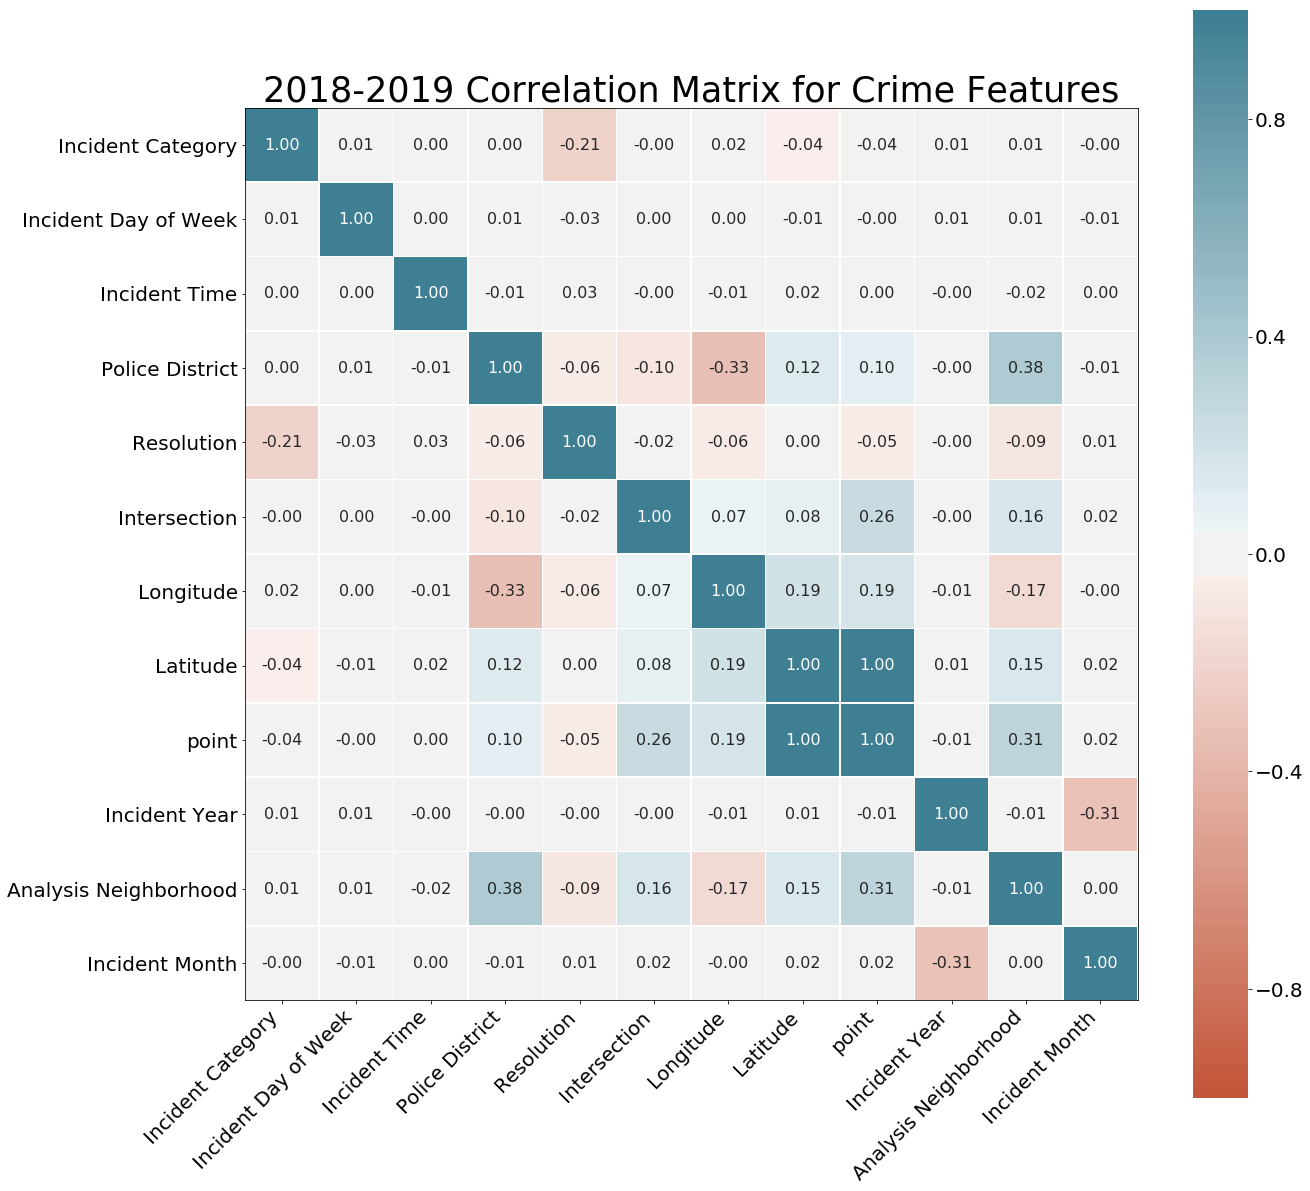

In [32]:
# Create dataframe with reports from 2018-2019 and plot correlation matrix
columns = ['Incident Category', 'Incident Day of Week', 'Incident Time', 'Police District', 'Resolution', 'Intersection', 'Longitude', 'Latitude', 'point', 'Incident Year', 'Analysis Neighborhood', 'Incident Month']
data_2018_2019 = df.copy()
data_2018_2019 = data_2018_2019[data_2018_2019["Incident Year"] > 2017]

# Add 'Incident Month' column and update "Incident Time" column to be by hour for easier reference
data_2018_2019["Incident Month"] = pd.to_datetime(data_2018_2019["Incident Date"]).dt.month
data_2018_2019 = data_2018_2019[columns]
data_2018_2019["Incident Time"] = data_2018_2019["Incident Time"].str.split(':').str[0]

def string_to_category(df):
    """Convert string columns of input crime dataframe to 'categorical codes' to be used for correlation matrix"""
    
    df["Incident Category"] = df["Incident Category"].astype('category').cat.codes
    df["Incident Day of Week"] = df["Incident Day of Week"].astype('category').cat.codes
    df["Incident Time"] = df["Incident Time"].astype('category').cat.codes
    df["Police District"] = df["Police District"].astype('category').cat.codes
    df["Resolution"] = df["Resolution"].astype('category').cat.codes
    df["Intersection"] = df["Intersection"].astype('category').cat.codes
    df["Analysis Neighborhood"] = df["Analysis Neighborhood"].astype('category').cat.codes
    df["point"] = df["point"].astype('category').cat.codes
    
    
string_to_category(data_2018_2019)
create_corr(data_2018_2019)

In [33]:
def get_rp_values(df, v1, v2_list):
    """Gets Pearson's r coefficient and p-values between v1 and the variables in v2_list"""
    r_values, p_values = [],[]
    for v2 in v2_list:
        rVal, pVal = stats.pearsonr(df[v1], df[v2])
        r_values.append(rVal)
        p_values.append(pVal)
        
    return r_values, p_values

In [34]:
# Create variable list for "Incident Category" to be compared to
comparison_cols = columns
comparison_cols.remove("Incident Category")

# Get Pearson's r coefficient and p-values
r_values, p_values = get_rp_values(data_2018_2019, "Incident Category", comparison_cols)
rp_values_df = pd.DataFrame({'R Coefficient':r_values, 'p-Value':p_values}, index=comparison_cols)

# Round p-Value column to 2 decimal places
rp_values_df["p-Value"] = rp_values_df["p-Value"].round(decimals=2)
rp_values_df = rp_values_df.rename_axis("Comparison Variable", axis="columns")
rp_values_df

Comparison Variable,R Coefficient,p-Value
Incident Day of Week,0.012394,0.00
Incident Time,0.004019,0.05
Police District,0.000557,0.78
Resolution,-0.211320,0.00
Intersection,-0.002224,0.27
Longitude,NaN,1.00
Latitude,NaN,1.00
point,-0.037138,0.00
Incident Year,0.008946,0.00
Analysis Neighborhood,0.012979,0.00


In [ ]:
# """Code to show example of crime per year for a specific police district"""
# years = df[df["Police District"] == "mission"].groupby("Incident Year").size().reset_index(name='number_of_crimes')
# print(years.iloc[0:16].number_of_crimes.describe())
# years.iloc[0:16]

In [182]:
# """Code to show example of a poisson r.v."""
# mu = pd_mean_dict["central"]

# test_rv = poisson(pd_mean_dict["central"])

# mean, var, skew, kurt = poisson.stats(mu, moments='mvsk')

# x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))

# fig, ax = plt.subplots(1, 1)
# ax.plot(x, poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
# ax.set_title("PMF for Central")
# ax.set_xlabel("Number of crimes")
# ax.set_ylabel("Probability")
# plt.show()
# print("Mu Value for Central: " + str(mu) + " crimes per year")
# print("Crimes in 2018: " + str(pd_yearly_dict["central"][15]))
# print("P-value for 24783: " + str(1- poisson.cdf(pd_yearly_dict["central"][15], mu)))
# print("P-value for mu: " + str(poisson.cdf(mu, mu)))

'Code to show example of a poisson r.v.'